<h1 style="text-align:center;"><b>Laboratorio 2</b></h1>
<h3 style="text-align:center;">Alina Carías (22539), Daniel Machic (22118), Ariela Mishaan (22052)</h3>

**Github**: https://github.com/ArielaMishaanCohen/LAB2.git  

# Librerías

In [44]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

## Task 1

**1. Cargar imagen en escala de grises**

In [45]:
img = cv2.imread("periodic_noise.jpeg", cv2.IMREAD_GRAYSCALE)
if img is None:
    raise FileNotFoundError("No se puede leer grises.png. Revisar el nombre y la ruta.")

**2. Calcular DFTy desplazar el componente de frecuencia cero al centro**

In [46]:
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)

**3. Mostrar espectro de magnitud en escala logarítmica**

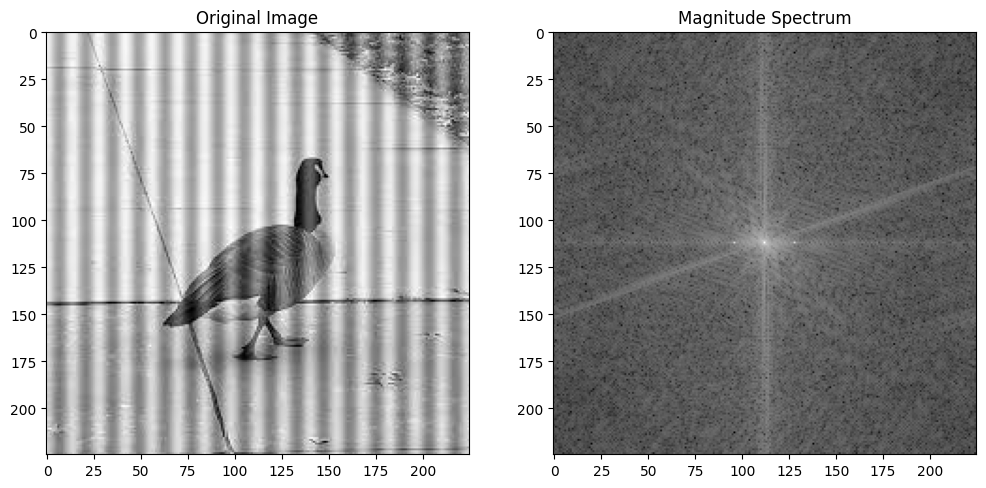

In [47]:
magnitude_spectrum = 20 * np.log(np.abs(fshift))

# Display the original image and its magnitude spectrum
plt.figure(figsize=(12, 6))
plt.subplot(121), plt.imshow(img, cmap='gray'), plt.title('Original Image')
plt.subplot(122), plt.imshow(magnitude_spectrum, cmap='gray'), plt.title('Magnitude Spectrum')
plt.show()

# Fuente: https://www.geeksforgeeks.org/computer-vision/fast-fourier-transform-in-image-processing/ 

**4. Picos de energía que no corresponden a la información natural de la imagen** 

En la imagen del espectro de magnitud se puede ver un punto brillante al centro, que es el componente DC (promedio de la imagen). Alrededor del centro hay una nube más o menos circular, lo que corresponde a bordes, formas y texturas reales del ganso y el fondo. Los picos de energía que se ven alrededor de la imagen, las líneas de "luz" fuera del centro, muestran un patrón bastante simétrico, lo cual significa que la imagen tiene ruido periódico. 

**5. Máscara (Notch Filter) para bloquear frecuencias parásitas (haciéndolas 0), preservando restro del espectro (incluyendo DC)**

In [48]:
# Fuente:https://stackoverflow.com/questions/65483030/notch-reject-filtering-in-python

def notch_reject_filter(shape, d0=9, u_k=0, v_k=0):
    P, Q = shape
    H = np.zeros((P, Q))

    for u in range(P):
        for v in range(Q):
            D_uv = np.sqrt((u - P/2 + u_k)**2 + (v - Q/2 + v_k)**2)
            D_muv = np.sqrt((u - P/2 - u_k)**2 + (v - Q/2 - v_k)**2)

            if D_uv <= d0 or D_muv <= d0:
                H[u, v] = 0
            else:
                H[u, v] = 1
    return H


In [49]:
rows, cols = img.shape

# NOTCHES 
H1 = notch_reject_filter((rows, cols), d0=6, u_k=0,  v_k=28)
H2 = notch_reject_filter((rows, cols), d0=6, u_k=0,  v_k=-28)
H3 = notch_reject_filter((rows, cols), d0=4, u_k=0,  v_k=56)
H4 = notch_reject_filter((rows, cols), d0=4, u_k=0,  v_k=-56)

NotchFilter = H1 * H2 * H3 * H4

# Aplicar filtro
filtered_shift = fshift * NotchFilter
filtered = np.fft.ifft2(np.fft.ifftshift(filtered_shift))
filtered = np.abs(filtered)

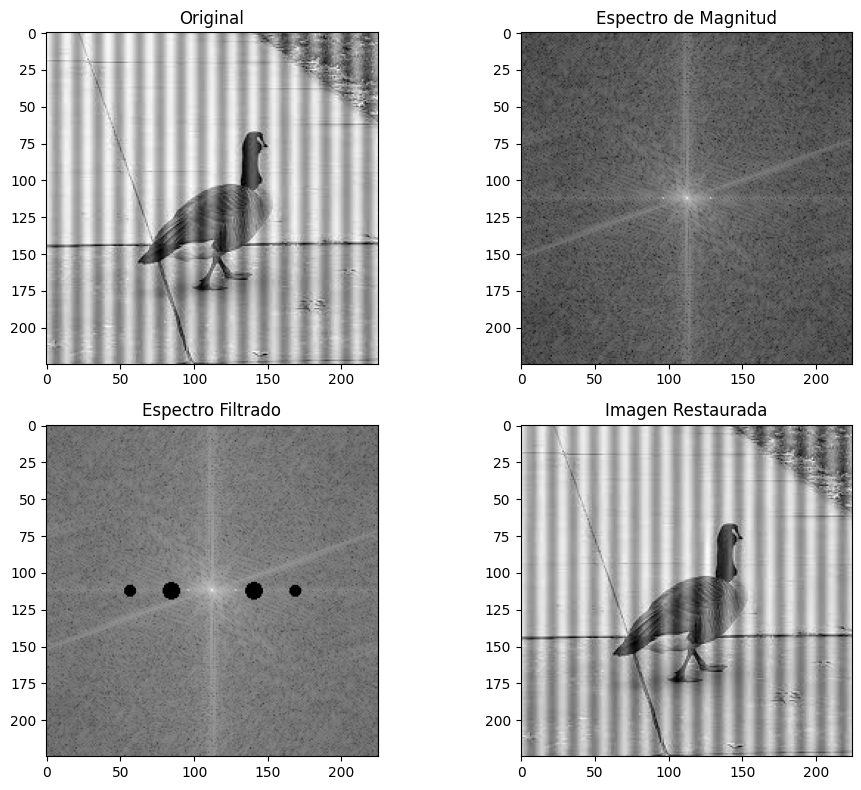

In [50]:
plt.figure(figsize=(10,8))

plt.subplot(221)
plt.imshow(img, cmap='gray')
plt.title("Original")

plt.subplot(222)
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title("Espectro de Magnitud")

plt.subplot(223)
plt.imshow(magnitude_spectrum * NotchFilter, cmap='gray')
plt.title("Espectro Filtrado")

plt.subplot(224)
plt.imshow(filtered, cmap='gray')
plt.title("Imagen Restaurada")

plt.tight_layout()
plt.show()

**6. Aplicar transformada inversa para recuperar imagen espacial**

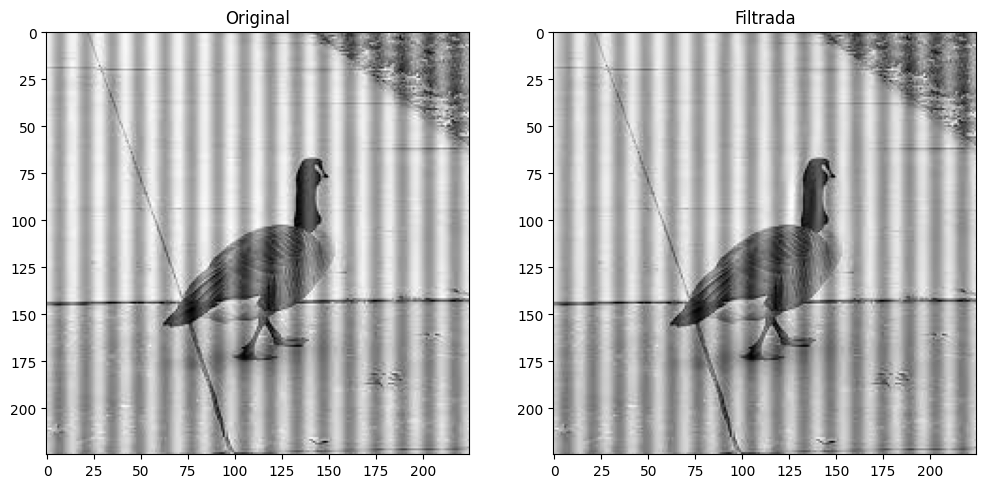

In [51]:
fshift_filtered = fshift * H
f_ishift = np.fft.ifftshift(fshift_filtered)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)

plt.figure(figsize=(12,6))
plt.subplot(121), plt.imshow(img, cmap='gray'), plt.title("Original")
plt.subplot(122), plt.imshow(img_back, cmap='gray'), plt.title("Filtrada")
plt.show()
